In [1]:
import pandas as pd
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row

In [2]:
accidents = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_41764\901670543.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv("../PrometneNesreče.csv")


In [3]:
# Priprava podatkov
accidents['NastanekDatumCas'] = pd.to_datetime(accidents['NastanekDatumCas'], format='ISO8601', errors='coerce')
print(f"NastanekDatumCas column dtype: {accidents['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns]


# CosinorPy - pomlad

In [6]:
spring_mask = accidents['NastanekDatumCas'].dt.month.isin([3, 4, 5])

spring_accidents = accidents[spring_mask]
# print(f"NastanekDatumCas column dtype: {spring_accidents['NastanekDatumCas'].dtype}")

hours = spring_accidents['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()
accidents_per_hour = accidents_per_hour.sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsSpring",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

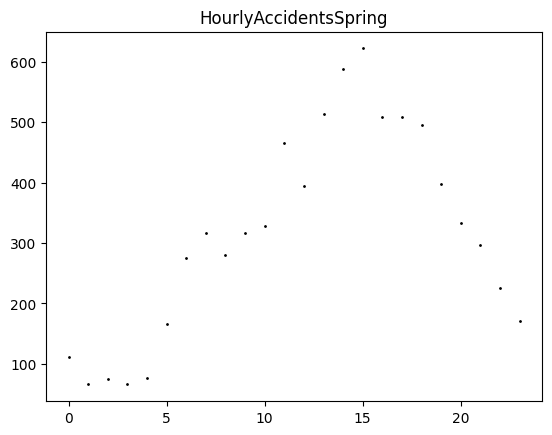

In [7]:
cosinor.plot_data(df_plot, names=["HourlyAccidentsSpring"])

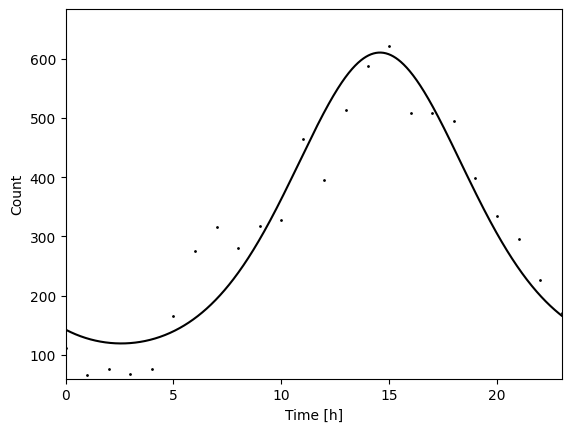

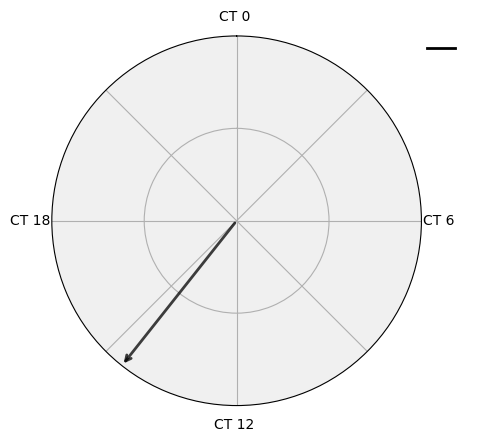

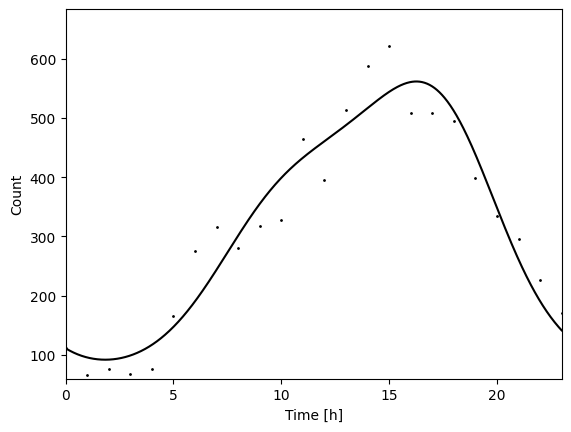

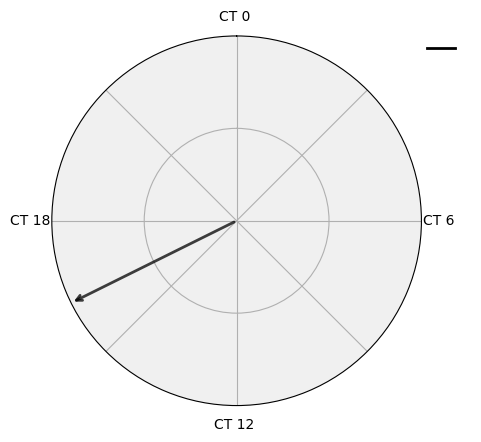

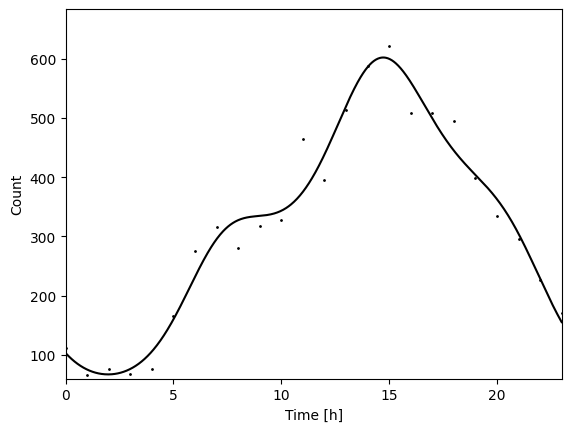

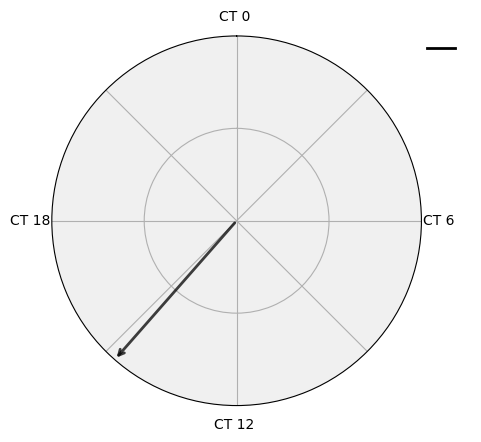

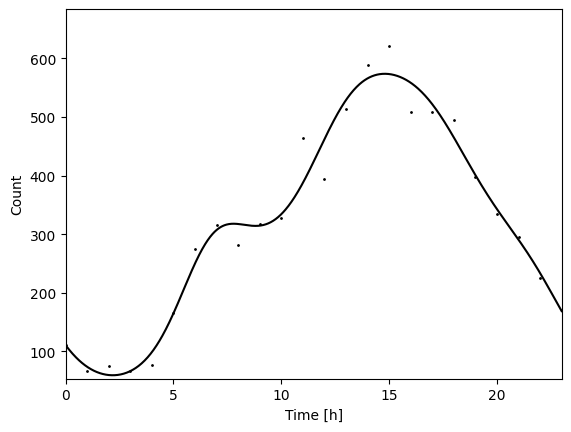

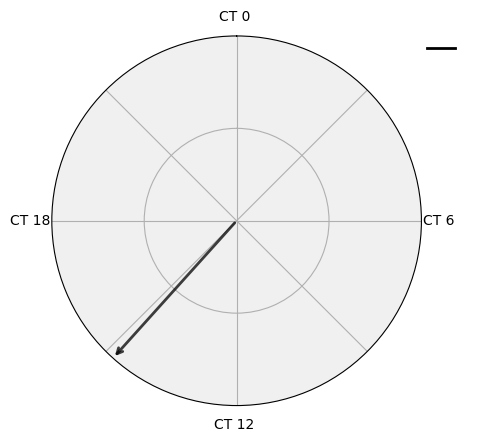

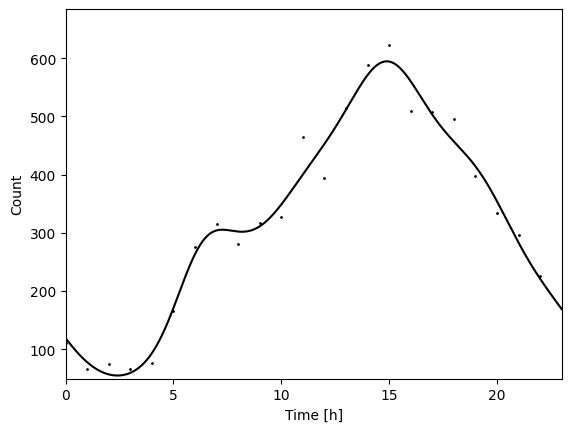

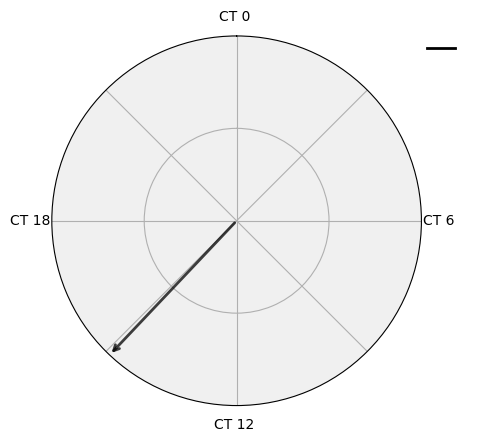

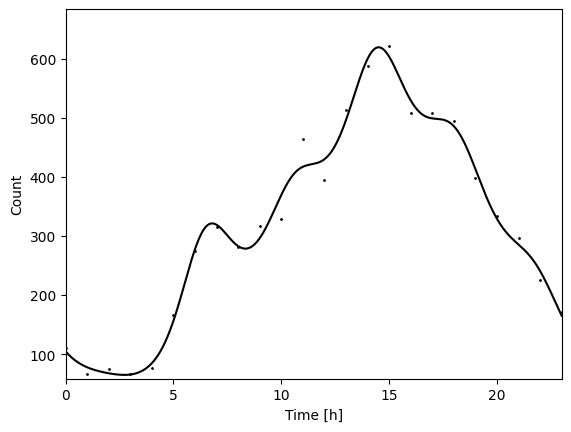

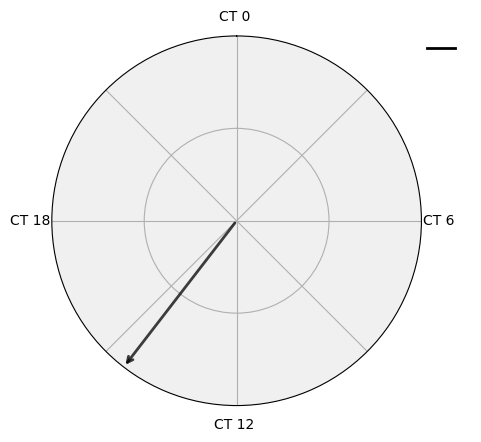

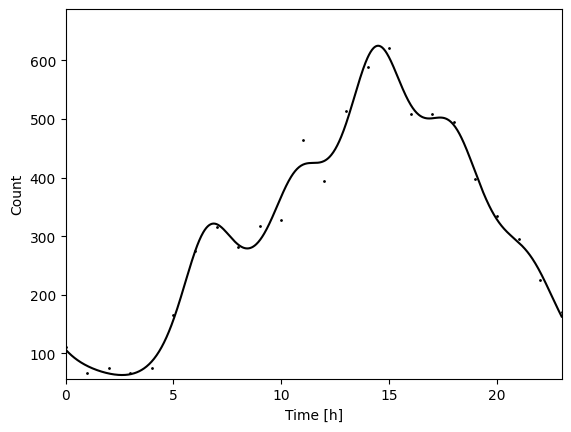

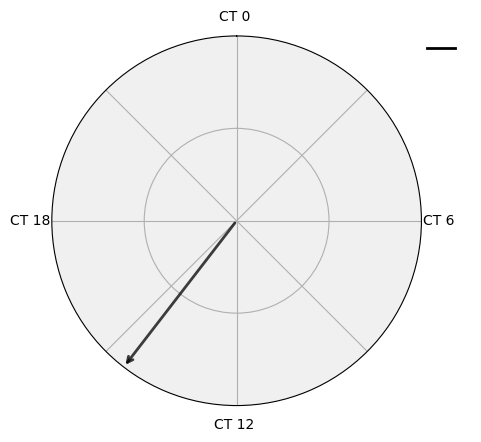

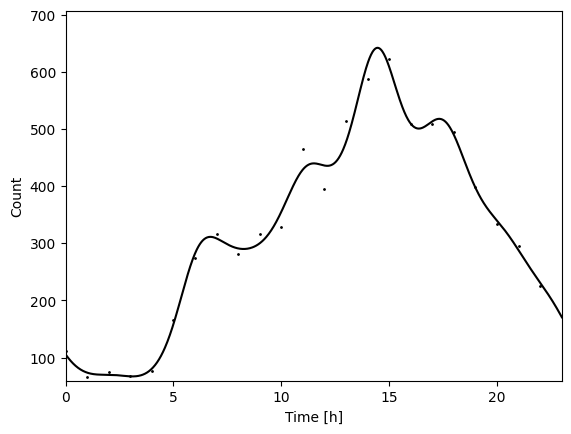

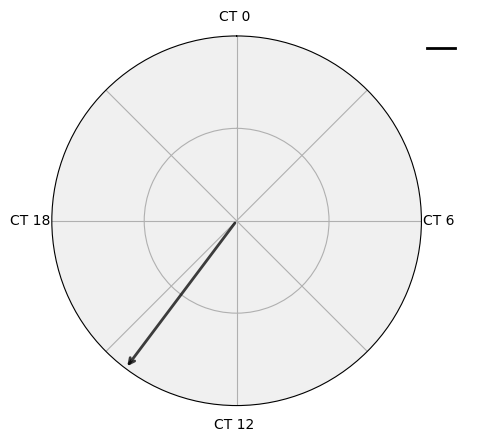

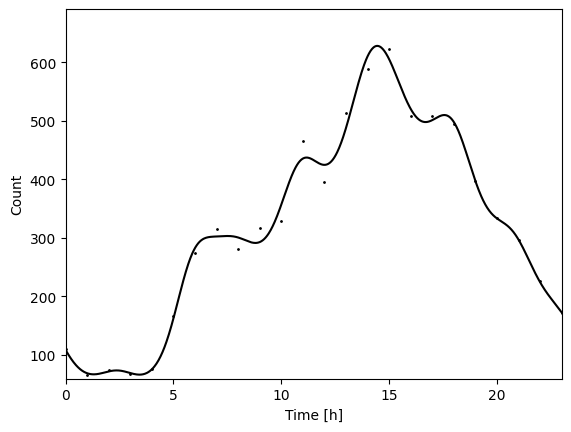

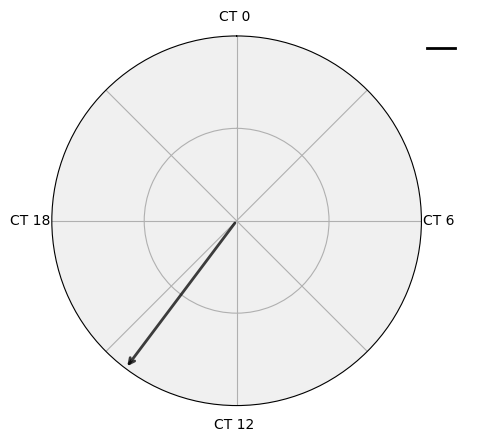

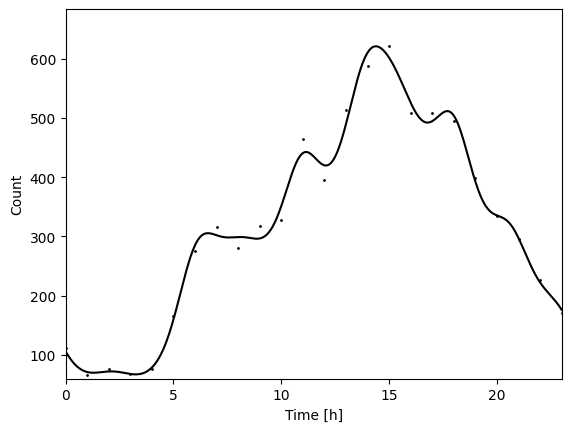

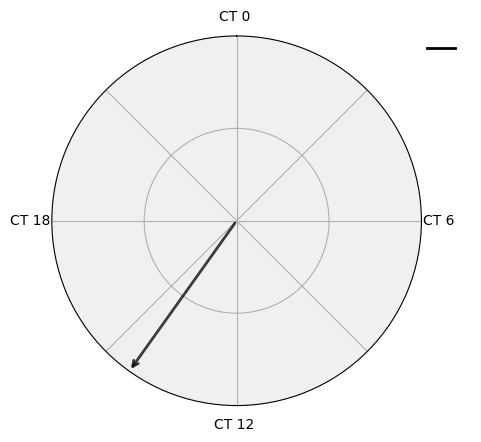

In [8]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsSpring', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [9]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsSpring,24.0,1.0,1.768213e-12,1.768213e-12,73216.509012,-131.820025,0.170323,245.869564,2.471764,364.907539,[14.558558558558559],[610.7732223292846],[2.5945945945945947],[119.03914357412924]
1,HourlyAccidentsSpring,24.0,2.0,4.400797e-14,4.889775e-14,50873.122634,-124.562256,0.216003,235.163213,2.031500,326.722201,[16.24024024024024],[561.8799747733152],[1.8258258258258258],[91.55898754756568]
2,HourlyAccidentsSpring,24.0,3.0,2.287278e-17,3.267540e-17,23080.113524,-113.587152,0.285081,267.856821,2.421448,334.564761,[14.75075075075075],[602.4046086325056],[1.96996996996997],[66.70793954337299]
3,HourlyAccidentsSpring,24.0,4.0,2.204461e-17,3.267540e-17,20184.654253,-110.627154,0.303711,257.250368,2.408869,316.580018,"[7.783783783783783, 14.7987987987988]","[317.9258995573223, 573.830385730096]","[2.1621621621621623, 8.792792792792794]","[59.333870825557554, 314.2275116520797]"
4,HourlyAccidentsSpring,24.0,5.0,3.835858e-17,4.794822e-17,15665.120167,-108.500182,0.317098,269.813226,2.383711,324.754987,[14.894894894894895],[594.5682125148328],"[2.4024024024024024, 8.168168168168169]","[54.941761368675365, 301.85882660311285]"
5,HourlyAccidentsSpring,24.0,6.0,3.079155e-19,3.079155e-18,8081.816933,-100.632450,0.366618,277.357329,2.484343,342.195805,[14.51051051051051],[619.55313415149],"[2.7387387387387387, 8.312312312312311]","[64.8413150974067, 278.6568993292797]"
6,HourlyAccidentsSpring,24.0,7.0,2.233313e-18,5.039962e-18,7433.193503,-100.287591,0.368788,280.931380,2.484343,344.171413,"[14.51051051051051, 17.345345345345343]","[625.0639772706046, 502.58143550328333]","[2.5945945945945947, 8.408408408408409]","[63.24258366131867, 279.23478953057366]"
7,HourlyAccidentsSpring,24.0,8.0,1.008588e-18,3.361961e-18,6824.036402,-96.970686,0.389665,287.658143,2.496921,354.618537,"[11.531531531531531, 14.462462462462462, 17.29...","[439.92003579239605, 642.2766800400032, 517.89...","[3.075075075075075, 8.264264264264265]","[66.96360396795183, 290.056304737458]"
8,HourlyAccidentsSpring,24.0,9.0,7.460056e-19,3.361961e-18,5486.992667,-94.269154,0.406668,280.805333,2.496921,347.175367,"[11.147147147147146, 14.462462462462462, 17.53...","[437.2108103298674, 627.9783555881769, 509.842...","[1.2972972972972974, 3.4114114114114114, 8.792...","[66.8917691991719, 66.37003430063922, 291.3479..."
9,HourlyAccidentsSpring,24.0,10.0,2.519981e-18,5.039962e-18,5014.943475,-93.376445,0.412287,277.320468,2.522079,344.055910,"[11.147147147147146, 14.366366366366366, 17.68...","[442.6867595152428, 621.3553461919996, 511.784...","[1.2972972972972974, 3.2672672672672673, 7.591...","[69.50768345941302, 66.74073600025145, 298.165..."


### Katero je najboljše število komponent

In [10]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsSpring,24.0,6.0,3.079155e-19,3.079155e-18,8081.816933,-100.63245,0.366618,277.357329,2.484343,342.195805,[14.51051051051051],[619.55313415149],"[2.7387387387387387, 8.312312312312311]","[64.8413150974067, 278.6568993292797]"


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


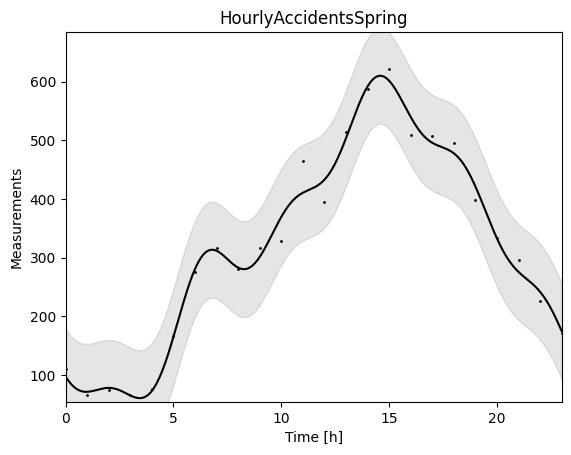

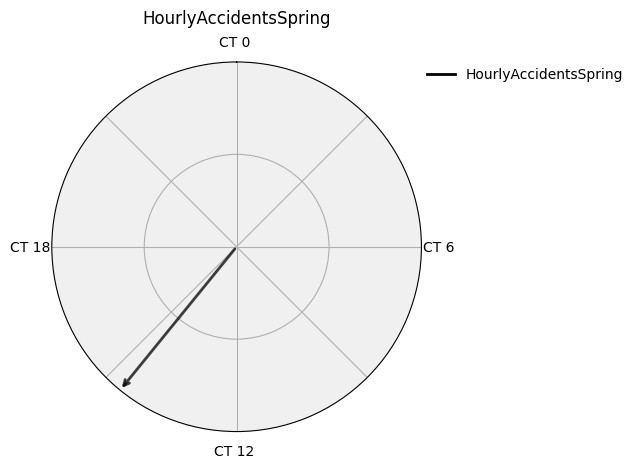

In [11]:
cosinor.plot_df_models(df_plot, df_best_model)